In [58]:
%pylab nbagg
from tvb.simulator.lab import *
import os.path
from matplotlib import colors, cm
import time
import scipy.signal as sig

import numpy as np
import pandas as pd
import scipy.io

# downloaded library for peak detection in z time series
import peakdetect
from runmainsim import *
import tvbsim

import re

import sys
sys.path.append('/Users/adam2392/Documents/fragility_analysis/')
import fragility.signalprocessing as sp

%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def renamefiles(patient, project_dir):
    ####### Initialize files needed to 
    # convert seeg.xyz to seeg.txt file
    sensorsfile = os.path.join(project_dir, "seeg.xyz")
    newsensorsfile = os.path.join(project_dir, "seeg.txt")
    try:
        os.rename(sensorsfile, newsensorsfile)
    except:
        print "Already renamed seeg.xyz possibly!"

    # convert gain_inv-square.mat file into gain_inv-square.txt file
    gainmatfile = os.path.join(project_dir, "gain_inv-square.mat")
    newgainmatfile = os.path.join(project_dir, "gain_inv-square.txt")
    try:
        os.rename(gainmatfile, newgainmatfile)
    except:
        print "Already renamed gain_inv-square.mat possibly!" 

# 1. Set Up Simulation Configuration First - Move Contact
Here, set everything from the ez region, connectivity, node model, coupling, monitors, integrator, and parameters.

In [43]:
patients = ['id001_ac', 'id002_cj', 'id014_rb']
patients = ['id002_cj']

MOVECONTACT = 1
# patients = ['id001_ac']
for patient in patients:
    print patient
#     patient='cj'
    # 1000 = 1 second
    samplerate = 1000 # Hz
    sim_length = 240*samplerate

    ezregion = ['ctx-lh-bankssts', 'ctx-lh-cuneus']
#     ezregion = ['ctx-lh-bankssts']
#     ezregion = []
    pzregion = ['ctx-lh-cuneus']
    pzregion = []

    outputdir = os.path.join('/Users/adam2392/Documents/pydata/tvb_forwardsim/', patient)
    if not os.path.exists(outputdir):
        os.mkdir(outputdir)
    filename = os.path.join(outputdir, patient+'_nonmovedsim_nez'+str(len(ezregion))+\
                                        '_npz'+str(len(pzregion))+'.npz')

    period = 1
    # x0c value = -2.05
    x0norm=-2.5
    x0ez=-1.6
    x0pz=-2.04
    
    # intialized hard coded parameters
    epileptor_r = 0.0002       # Temporal scaling in the third state variable
    epiks = -0.5                 # Permittivity coupling, fast to slow time scale
    epitt = 0.05               # time scale of simulation
    epitau = 10                # Temporal scaling coefficient in fifth st var

    # depends on epileptor variables of interest: it is where the x2-y2 var is
    varindex = [1]
    
    # parameters for heun-stochastic integrator
    heun_ts = 0.05
    noise_cov = np.array([0.001, 0.001, 0.,\
                    0.0001, 0.0001, 0.])
    
    root_dir = os.getcwd()
    project_dir = os.path.join(root_dir, "metadata/"+patient)
    print "Project directory for meta data is : ", project_dir
    print "File to be saved is: ", filename
    renamefiles(patient, project_dir)
    
    ####### Initialize files needed to 
    # convert seeg.xyz to seeg.txt file
    sensorsfile = os.path.join(project_dir, "seeg.txt")
    # convert gain_inv-square.mat file into gain_inv-square.txt file
    gainmatfile = os.path.join(project_dir, "gain_inv-square.txt")
    
    confile = os.path.join(project_dir, "connectivity.zip")
    ####################### 1. Structural Connectivity ########################
    con = initconn(confile)
    
    # extract the seeg_xyz coords and the region centers
    seeg_xyz = tvbsim.util.extractseegxyz(sensorsfile)
    seeg_labels = seeg_xyz.index.values
    region_centers = con.centres
    regions = con.region_labels
    num_regions = len(regions)
    
    # initialize object to assist in moving seeg contacts
    movecontact = tvbsim.util.MoveContacts(seeg_labels, seeg_xyz, 
                                       regions, region_centers, True)
    
    ezindices = movecontact.getindexofregion(ezregion)
    pzindices = movecontact.getindexofregion(pzregion)
    
    # move electrodes onto ez indices
    elecmovedindices = []
    for ezindex in ezindices:
        print "Moving onto current ez index: ", ezindex, " at ", regions[ezindex]
         # find the closest contact index and distance
        seeg_index, distance = movecontact.findclosestcontact(ezindex, elecmovedindices)
        
        # get the modified seeg xyz and gain matrix
        modseeg, electrodeindices = movecontact.movecontact(ezindex, seeg_index)
        elecmovedindices.append(electrodeindices)
        
    modgain = movecontact.simplest_gain_matrix(movecontact.seeg_xyz)
    
    ####################### 2. Neural Mass Model @ Nodes ######################
    epileptors = initepileptor(epileptor_r, epiks, epitt, epitau, x0norm, \
                              x0ez, x0pz, ezindices, pzindices, num_regions)    
    ####################### 3. Integrator for Models ##########################
    heunint = initintegrator(heun_ts, noise_cov)
    ################## 4. Difference Coupling Between Nodes ###################
    coupl = initcoupling(a=1.)
    ############## 5. Import Sensor XYZ, Gain Matrix For Monitors #############
    monitors = initmonitors(period, sensorsfile, gainmatfile, varindex)
    
    if MOVECONTACT:
        # modify the config of the monitors
        monitors[1].sensors.locations = movecontact.seeg_xyz
        monitors[1].gain = modgain
    
    # get initial conditions and then setup entire simulation configuration
    initcond = initconditions(x0norm, num_regions)
#     sim, configs = setupconfig(epileptors, con, coupl, heunint, monitors, initcond)

id002_cj
Project directory for meta data is :  /Users/adam2392/Documents/tvb/metadata/id002_cj
File to be saved is:  /Users/adam2392/Documents/pydata/tvb_forwardsim/id002_cj/id002_cj_nonmovedsim_nez2_npz0.npz
Already renamed seeg.xyz possibly!
Already renamed gain_inv-square.mat possibly!
Moving onto current ez index:  0  at  ctx-lh-bankssts
GPH'4
GPH
[-44.62 -36.16 -22.87]


 movecontact function summary: 

Closest contact to ezregion:  [-47.4046 -46.2536 -24.7605]  is  GPH'4
That is located at:  [-47.4046 -46.2536 -24.7605]
It will move:  [-2.7846000000000046, -10.093600000000002, -1.8904999999999994]
New location after movement is [-47.4046 -46.2536 -24.7605]



Moving onto current ez index:  3  at  ctx-lh-cuneus
CU'1
CU
[-14.39 -76.81 -14.89]


 movecontact function summary: 

Closest contact to ezregion:  [ -7.9202 -83.8659 -14.3875]  is  CU'1
That is located at:  [ -7.9202 -83.8659 -14.3875]
It will move:  [6.4698000000000002, -7.0558999999999941, 0.50250000000000128]
New locatio

In [19]:
times, epilepts, seegts = runsim(sim, sim_length)

postprocessor = PostProcess(epilepts, seegts, times)
######################## POST PROCESSING #################################
# post process by cutting off first 5 seconds of simulation
# for now, don't, since intiial conditions
times, epits, seegts, zts = postprocessor.postprocts(samplerate)

# get the onset, offset times
onsettimes = None
offsettimes = None
try:
    onsettimes, offsettimes = PostProcess.findonsetoffset(zts[ezindices, :].squeeze())
except:
    print "Still not working..."

######################## SAVING ALL DATA #################################
regions = configs.connectivity.region_labels
# Save files
meta = {
    'x0ez':x0ez,
    'x0pz':x0pz,
    'x0norm':x0norm,
    'regions': regions,
    'regions_centers': configs.connectivity.centres,
    'seeg_contacts': configs.monitors[1].sensors.labels,
    'seeg_xyz': configs.monitors[1].sensors.locations,
    'ez': regions[ezindices],
    'pz': regions[pzindices],
    'ezindices': ezindices,
    'pzindices': pzindices,
    'onsettimes':onsettimes,
    'offsettimes':offsettimes,
    'patient':patient,
}

# save tseries
np.savez(filename, epits=epits, seegts=seegts, \
         times=times, zts=zts, metadata=meta)

KeyboardInterrupt: 

# 2. Apply EZ To Closest Region

Here, set everything from the ez region, connectivity, node model, coupling, monitors, integrator, and parameters.

In [34]:
patient = 'id014_rb'

root_dir = os.getcwd()
project_dir = os.path.join(root_dir, "metadata/"+patient)
renamefiles(patient, project_dir)

####### Initialize files needed to 
sensorsfile = os.path.join(project_dir, "seeg.txt")
confile = os.path.join(project_dir, "connectivity.zip")
gainmatfile = os.path.join(project_dir, "gain_inv-square.txt")

con = initconn(confile)

# extract the seeg_xyz coords and the region centers
seeg_xyz = tvbsim.util.extractseegxyz(sensorsfile)
seeg_labels = seeg_xyz.index.values
    
# extract the seeg_xyz coords and the region centers
region_centers = con.centres
regions = con.region_labels
num_regions = len(regions)

Already renamed seeg.xyz possibly!
Already renamed gain_inv-square.mat possibly!


In [42]:
# initialize object to assist in moving seeg contacts
movecontact = tvbsim.util.MoveContacts(seeg_labels, seeg_xyz, 
                                   regions, region_centers, True)

for idx, label in enumerate(seeg_labels):
    region_index, distance = movecontact.getregionsforcontacts(label)
    
    if idx == 0:
        mindist = distance
        minregion = region_index
        mincontact = label
    else:
        if distance < mindist:
            mindist = distance
            minregion = region_index
            mincontact = label

print patient
print "Project directory for meta data is : ", project_dir
print "File to be saved is: ", filename
print mincontact
print mindist
print minregion
print regions[minregion]
sim, configs = setupconfig(epileptors, con, coupl, heunint, monitors, initcond)

id002_cj
Project directory for meta data is :  /Users/adam2392/Documents/tvb/metadata/id014_rb
File to be saved is:  /Users/adam2392/Documents/pydata/tvb_forwardsim/id002_cj/id002_cjcloseregion_TESTTESTsim_nez1_npz1.npz
B'8
[ 0.46737425]
[13]
['ctx-lh-middletemporal']


In [40]:
patient = 'id002_cj'
# 1000 = 1 second
samplerate = 1000 # Hz
sim_length = 30*samplerate

ezregion = ['ctx-lh-bankssts', 'ctx-lh-cuneus']
ezregion = ['ctx-lh-bankssts']
ezregion = regions[minregion]
#     ezregion = []
pzregion = ['ctx-lh-cuneus']
# pzregion = [] 

outputdir = os.path.join('/Users/adam2392/Documents/pydata/tvb_forwardsim/', patient)
if not os.path.exists(outputdir):
    os.mkdir(outputdir)
filename = os.path.join(outputdir, patient+'closeregion_TESTTESTsim_nez'+str(len(ezregion))+\
                                    '_npz'+str(len(pzregion))+'.npz')

period = 1
# x0c value = -2.05
x0norm=-2.5
x0ez=-1.6
x0pz=-2.0

# intialized hard coded parameters
epileptor_r = 0.0002       # Temporal scaling in the third state variable
epiks = -0.5                 # Permittivity coupling, fast to slow time scale
epitt = 0.05               # time scale of simulation
epitau = 10                # Temporal scaling coefficient in fifth st var

# depends on epileptor variables of interest: it is where the x2-y2 var is
varindex = [1]

# parameters for heun-stochastic integrator
heun_ts = 0.05
noise_cov = np.array([0.001, 0.001, 0.,\
                0.0001, 0.0001, 0.])

print patient, " will be simulated for ", sim_length
print ezregion
print "output dir is: ", outputdir
print filename

id002_cj  will be simulated for  30000
['ctx-lh-middletemporal']
output dir is:  /Users/adam2392/Documents/pydata/tvb_forwardsim/id002_cj
/Users/adam2392/Documents/pydata/tvb_forwardsim/id002_cj/id002_cjcloseregion_TESTTESTsim_nez1_npz1.npz


In [19]:
####################### 1. Structural Connectivity ########################
con = initconn(confile)

# extract the seeg_xyz coords and the region centers
seeg_xyz = tvbsim.util.extractseegxyz(sensorsfile)
seeg_labels = seeg_xyz.index.values
region_centers = con.centres
regions = con.region_labels
num_regions = len(regions)

# initialize object to assist in moving seeg contacts
movecontact = tvbsim.util.MoveContacts(seeg_labels, seeg_xyz, 
                                   regions, region_centers, True)

ezindices = movecontact.getindexofregion(ezregion)
pzindices = movecontact.getindexofregion(pzregion)

####################### 2. Neural Mass Model @ Nodes ######################
epileptors = initepileptor(epileptor_r, epiks, epitt, epitau, x0norm, \
                          x0ez, x0pz, ezindices, pzindices, num_regions)    
####################### 3. Integrator for Models ##########################
heunint = initintegrator(heun_ts, noise_cov)
################## 4. Difference Coupling Between Nodes ###################
coupl = initcoupling(a=1.)
############## 5. Import Sensor XYZ, Gain Matrix For Monitors #############
monitors = initmonitors(period, sensorsfile, gainmatfile, varindex)

# get initial conditions and then setup entire simulation configuration
initcond = initconditions(x0norm, num_regions)

In [20]:
sim, configs = setupconfig(epileptors, con, coupl, heunint, monitors, initcond)

In [21]:
times, epilepts, seegts = runsim(sim, sim_length)

postprocessor = tvbsim.util.PostProcess(epilepts, seegts, times)
######################## POST PROCESSING #################################
# post process by cutting off first 5 seconds of simulation
# for now, don't, since intiial conditions
times, epits, seegts, zts = postprocessor.postprocts(samplerate)

# get the onset, offset times
onsettimes = None
offsettimes = None
try:
    onsettimes, offsettimes = postprocessor.findonsetoffset(zts[ezindices, :].squeeze())
except:
    print "Still not working..."

######################## SAVING ALL DATA #################################
regions = configs.connectivity.region_labels
# Save files
meta = {
    'x0ez':x0ez,
    'x0pz':x0pz,
    'x0norm':x0norm,
    'regions': regions,
    'regions_centers': configs.connectivity.centres,
    'seeg_contacts': configs.monitors[1].sensors.labels,
    'seeg_xyz': configs.monitors[1].sensors.locations,
    'ez': regions[ezindices],
    'pz': regions[pzindices],
    'ezindices': ezindices,
    'pzindices': pzindices,
    'onsettimes':onsettimes,
    'offsettimes':offsettimes,
    'patient':patient,
}

# save tseries
np.savez(filename, epits=epits, seegts=seegts, \
         times=times, zts=zts, metadata=meta)

Still not working...


In [25]:
print ezindices
onsettimes, offsettimes = postprocessor.findonsetoffset(zts[ezindices, :].squeeze(), delta=0)

[13]


## 2. Do a Quick Visualization of Raw Data

In [42]:
patient = 'id002_cj'
# patient = 'id001_ac'
eznum=1
pznum=1

# Set the directory and file to read
outputdir = os.path.join('/Users/adam2392/Documents/pydata/tvb_forwardsim/', patient)
if not os.path.exists(outputdir):
    os.mkdir(outputdir)
filename = os.path.join(outputdir, patient+'closeregion_TESTTESTsim_nez'+str(eznum)+\
                                '_npz'+str(pznum)+'.npz')
# load simulated data
data = np.load(filename)

# extract data and metadata from simulation
epits = data['epits']
zts = data['zts']
times = data['times']
seegts = data['seegts']

metadata = data['metadata'].item()
seeg_labels = metadata['seeg_contacts']
seeg_xyz = metadata['seeg_xyz']
region_labels = metadata['regions']
region_centers = metadata['regions_centers']
ezregions = metadata['ez']
pzregions = metadata['pz']
ezindices = metadata['ezindices']
onsettimes = metadata['onsettimes']
offsettimes = metadata['offsettimes']


print filename
# print findonsetoffset(zts[ezindices,:])
print data.keys()
print "Meta data contains: ", metadata.keys()
print "ez indices: ", metadata['ezindices']
print "ez region: ", ezregions
print "pz indices: ", metadata['pzindices']
print "pz region: ", pzregions

postprocessor = tvbsim.util.PostProcess(epits, seegts, times)
onsettimes, offsettimes = postprocessor.findonsetoffset(zts[ezindices, :].squeeze())

# initialize object to assist in moving seeg contacts
movecontact = tvbsim.util.MoveContacts(seeg_labels, seeg_xyz, 
                                       region_labels, region_centers, True)
# find the closest contact index and distance
ezseegindex, distance = movecontact.findclosestcontact(ezindex)

# initialize dsp object to perform dsp fitlering
dspobject = sp.filters.SignalProcessing(seegts)
seegts = dspobject.filterrawdata(freqrange=[59.5, 60.5], )


print ezseegindex, distance
print seeg_labels[ezseegindex]

/Users/adam2392/Documents/pydata/tvb_forwardsim/id002_cj/id002_cjcloseregion_TESTTESTsim_nez1_npz1.npz
['metadata', 'zts', 'seegts', 'epits', 'times']
Meta data contains:  ['patient', 'pz', 'onsettimes', 'seeg_xyz', 'x0ez', 'regions_centers', 'regions', 'seeg_contacts', 'offsettimes', 'x0pz', 'ez', 'pzindices', 'x0norm', 'ezindices']
ez indices:  [13]
ez region:  ['ctx-lh-middletemporal']
pz indices:  [3]
pz region:  ['ctx-lh-cuneus']
22 0.467374250467
B'8


In [59]:
# get the cortical surface meta data
metadatadir = os.path.join("/Users/adam2392/Documents/tvb/metadata/", patient)
cort_surf = surfaces.CorticalSurface.from_file(source_file=os.path.join(metadatadir, "surface_cort.zip"))
cort_surf.configure()
display(cort_surf.summary_info)

# read in seeg file
seeg = pd.read_csv(os.path.join(metadatadir, "seeg.txt"), names=['x', 'y', 'z'], delim_whitespace=True)
seeg_labels = seeg.index
seeg_xyz = seeg.as_matrix()

elect = []
dipole = []

# create lists of elect and dipoles
for element in range(0,seeg.shape[0]):
    kpm = np.array(re.match("([A-Z]+[a-z]*[']*)([0-9]+)", seeg_labels[element]).groups())
    elect.append(kpm[0])
    dipole.append(int(kpm[1]))

'''
Descrip: 
- Number of electrodes is : len(find_0)
- Number of contacts per an electrode i is nbr_contacts[i+1]

''' 
# find the beginning index of each electrode
find_0 = []
nbr_contacts = []
for element_1 in range(0, len(dipole)):
    if dipole[element_1] == 1:
        find_0.append(element_1)
for element_2 in range(0, len(find_0)-1):
    nbr_contacts.append(find_0[element_2+1]-find_0[element_2])
nbr_contacts.append(len(seeg_labels)- find_0[len(find_0)-1])

# Find the list of the ending index of each electrode
incr_cont = np.zeros((len(nbr_contacts)), dtype=int)
incr_cont[0] = 0

for element_4 in range(0, len(nbr_contacts)):
    incr_cont[element_4] = incr_cont[element_4-1] + nbr_contacts[element_4]

    
print "Nbre_contacts_per_electrode:", nbr_contacts
print "Nbre_electrodes:", len(nbr_contacts)
print "Ending Index of electrodes:", incr_cont # To plot each electrode with diff color

print sum(nbr_contacts) # to be sure that the code is correct
print len(seeg_labels)

{'Edge lengths, longest (mm)': 6.996888413149663,
 'Edge lengths, mean (mm)': 1.0136281714598714,
 'Edge lengths, shortest (mm)': 0.023021098605408456,
 'Has two hemispheres': False,
 'Number of edges': 756813,
 'Number of triangles': 504542,
 'Number of vertices': 252275,
 'Surface type': 'CorticalSurface',
 'Valid for simulations': False}

Nbre_contacts_per_electrode: [7, 14, 8, 14, 14, 14, 13, 13, 13, 13, 14, 12, 13]
Nbre_electrodes: 13
Ending Index of electrodes: [  7  21  29  43  57  71  84  97 110 123 137 149 162]
162
162


<IPython.core.display.Javascript object>


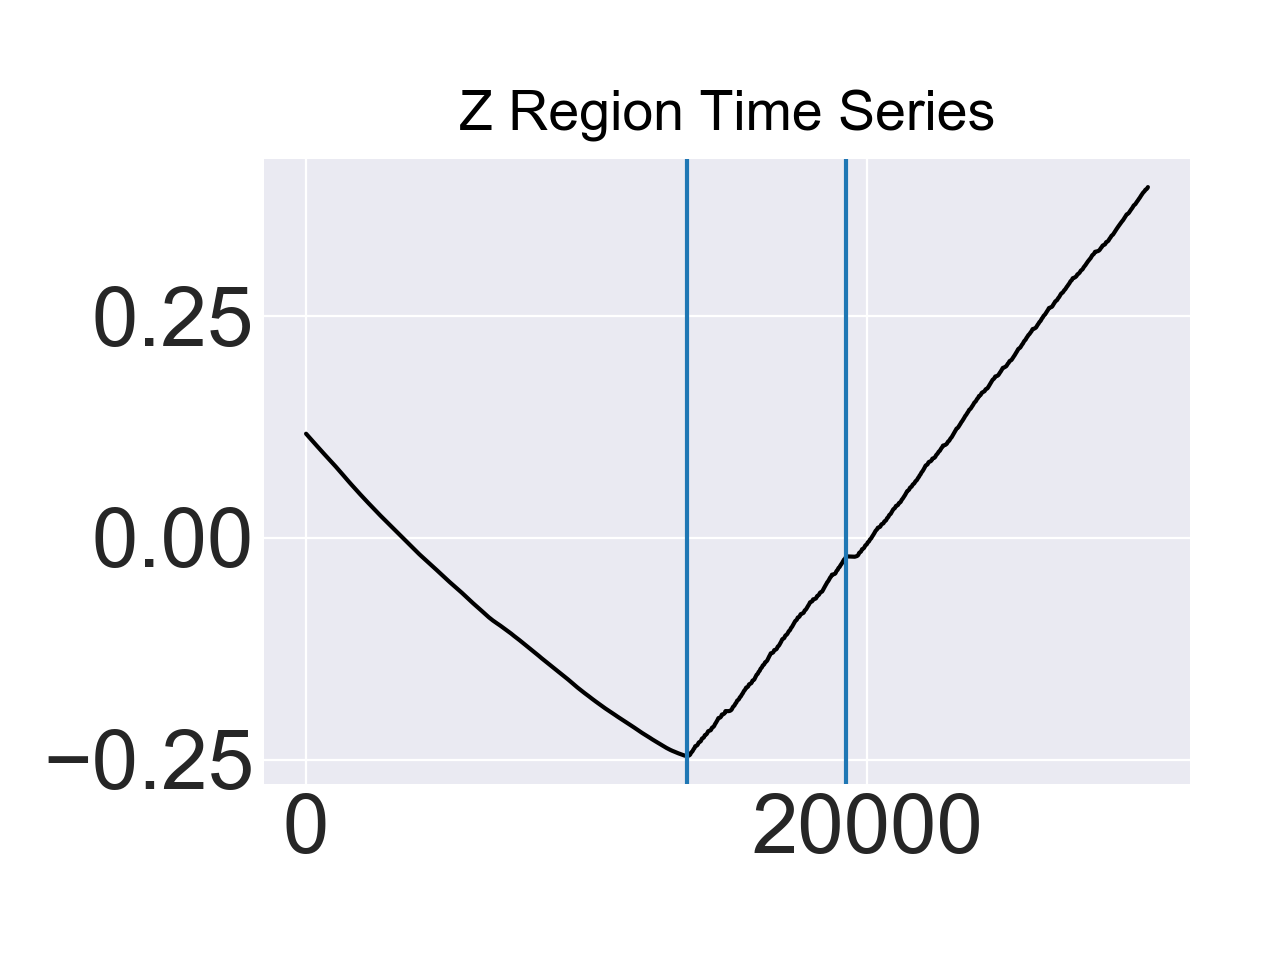

<IPython.core.display.Javascript object>


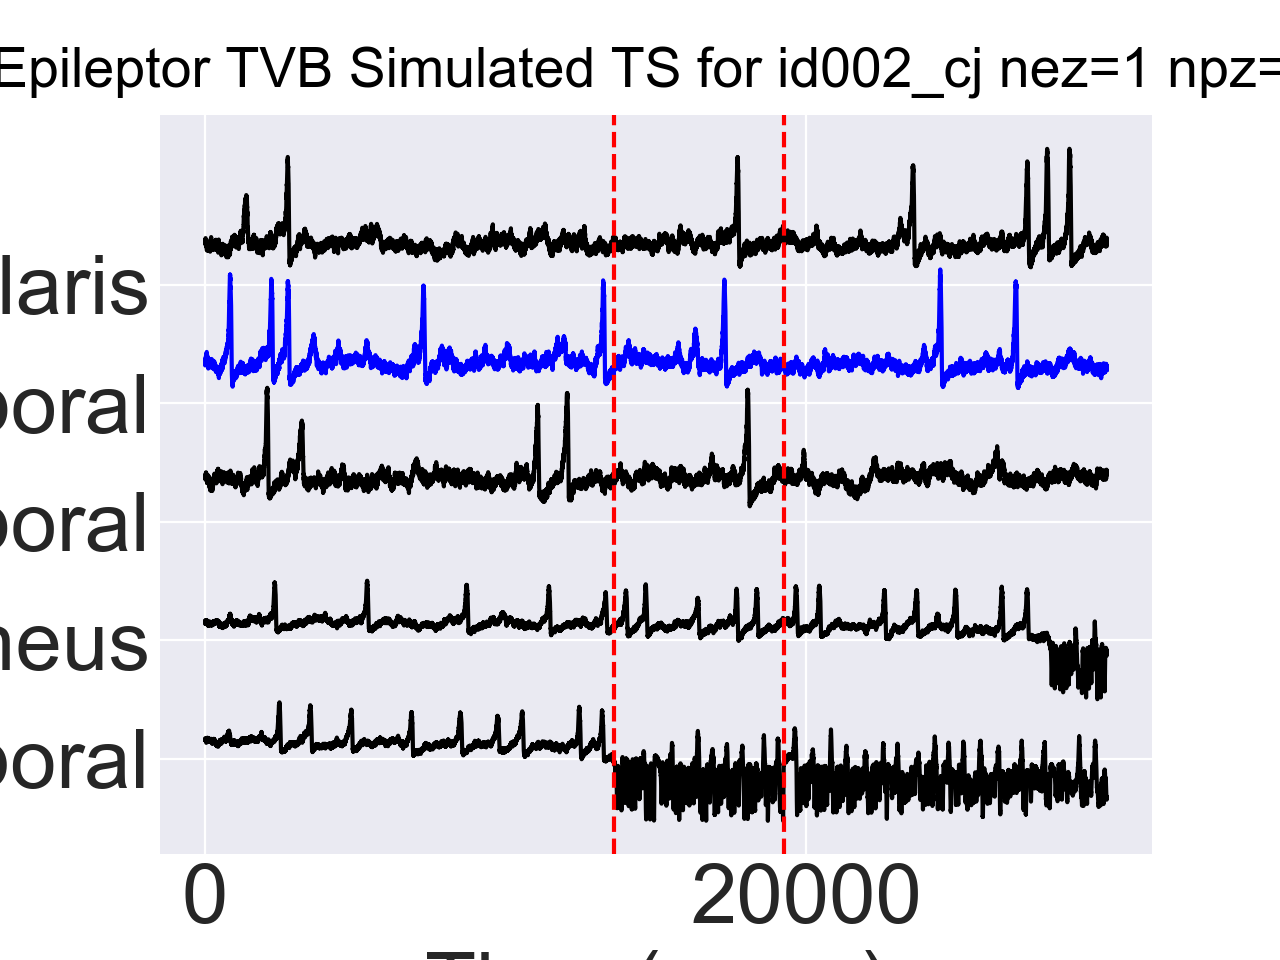

ezreion is:  ['ctx-lh-middletemporal']
pzregion is:  ['ctx-lh-cuneus']
x0 values are (ez, pz, norm):  -1.6 -2.0 -2.5
time series shape is:  (84, 30000)
here: [13  3 28 77 18]
[13  3 28 77 18]
can't tight layout


<IPython.core.display.Javascript object>


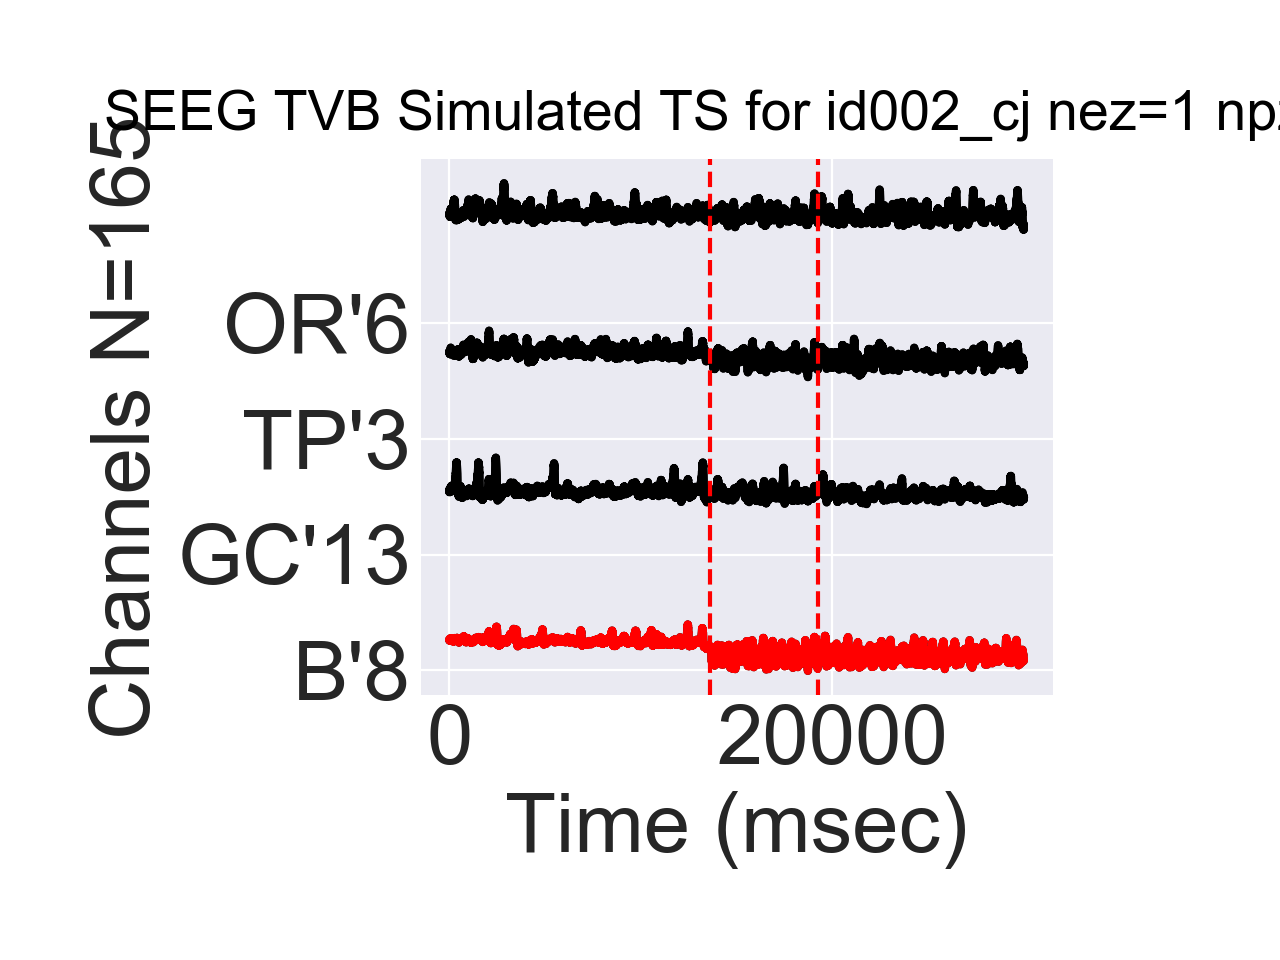

ez seeg index is:  22
here: [  22.   42.  157.  125.]
ezreion is:  ['ctx-lh-middletemporal']
pzregion is:  ['ctx-lh-cuneus']
x0 values are (ez, pz, norm):  -1.6 -2.0 -2.5
time series shape is:  (165, 30000)
ez seeg index is:  22
chanstoplot are:  [ 22  42 157 125]


<IPython.core.display.Javascript object>


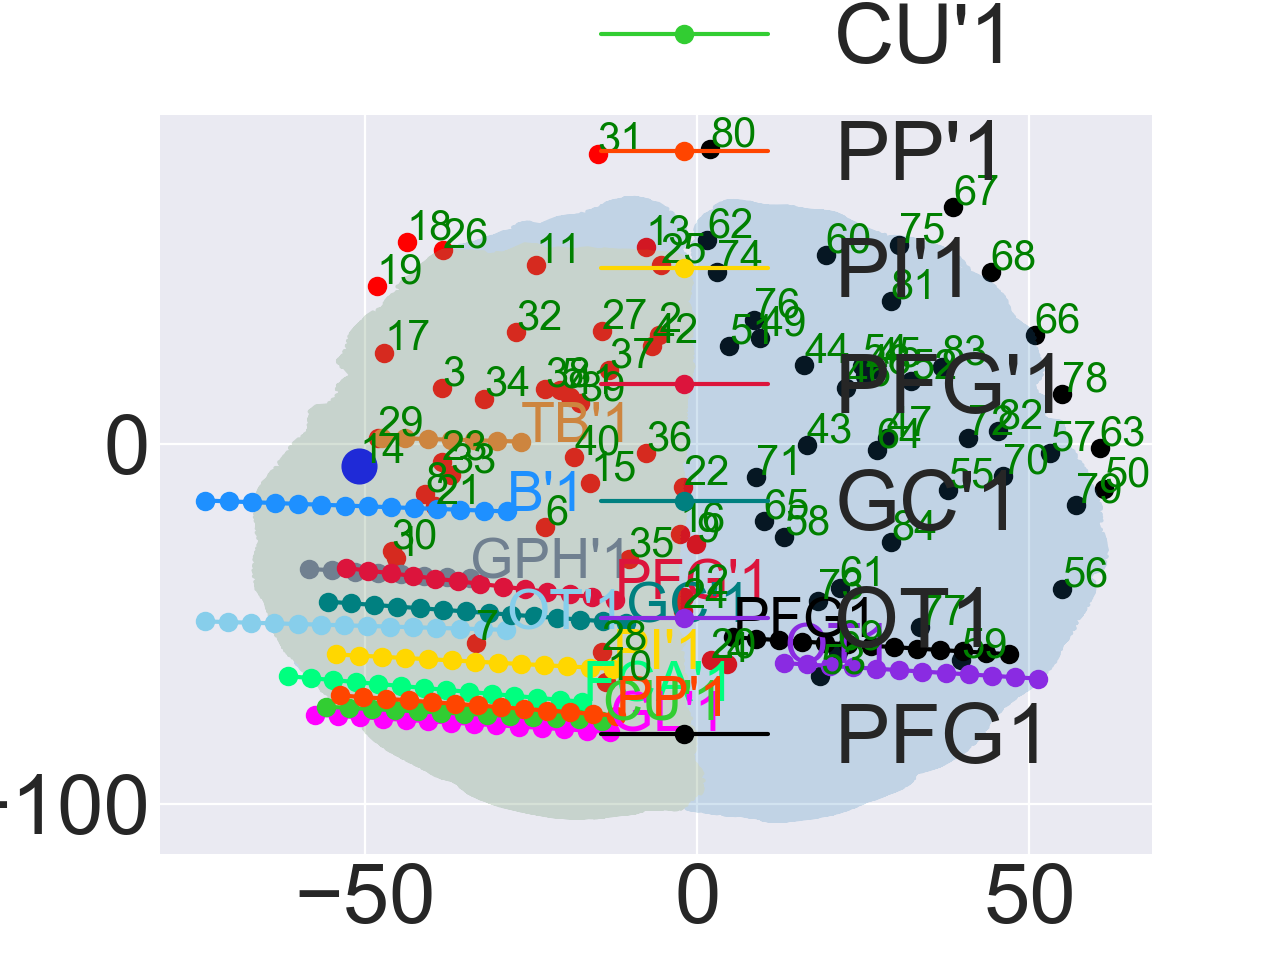

num regions:  84
num contacts:  162
13
xreg:  (84,)
yreg:  (84,)
zreg:  (84,)
[13]
[]


In [65]:
### Set the font dictionaries (for plot title and axis titles)
title_font = {'fontname':'Arial', 'size':'20', 'color':'black', 'weight':'normal',
          'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'family':'Arial', 'size':'30'}

color_new = ['peru', 'dodgerblue', 'slategrey', 
             'skyblue', 'springgreen', 'fuchsia', 'limegreen', 
             'orangered',  'gold', 'crimson', 'teal', 'blueviolet', 'black', 'cyan', 'lightseagreen',
             'lightpink', 'red', 'indigo', 'mediumorchid', 'mediumspringgreen']

rawplotter = tvbsim.visualize.RawPlotter(axis_font, title_font, color_new)
for ezindex in ezindices:
    zfig = rawplotter.plotzts(zts[ezindex,:]-np.mean(zts[ezindex,:]), ezindex, list(onsettimes), list(offsettimes))

rawplotter.initializefig()
epifig = rawplotter.plotepileptorts(epits, times, metadata, patient, onsettimes, offsettimes, plotsubset=True)

rawplotter.initializefig()
seegfig = rawplotter.plotseegts(seegts, times, metadata, onsettimes, offsettimes, patient, ezseegindex, plotsubset=True)

rawplotter.initializefig()
rawplotter.plotcontactsinbrain(cort_surf, region_centers, region_labels, seeg_xyz, seeg_labels, incr_cont, ezindices, pzindices=[])